In [ ]:
# Step 1: Install the required packages
!pip install pennylane pennylane-lightning numpy scikit-learn scipy joblib

# Step 2: Import necessary libraries
import time
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from scipy.optimize import minimize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Load the Iris dataset and select samples from two classes (class 0 and class 1)
data = load_iris()
X = data.data
y = data.target

# Select samples from class 0 and class 1 only
class_0 = X[y == 0][:15]  # First 15 samples of class 0
class_1 = X[y == 1][:15]  # First 15 samples of class 1

# Combine the selected samples
X = np.concatenate([class_0, class_1], axis=0)
y = np.array([0]*15 + [1]*15)

# Print dataset information
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution: {np.bincount(y)}")

# Define the number of qubits
n_qubits = X.shape[1]
dev = qml.device('default.qubit', wires=n_qubits)

# Define the quantum feature map
def quantum_feature_map(x, params):
    for i in range(n_qubits):
        qml.RY(x[i % len(x)], wires=i)
    for i in range(n_qubits):
        qml.RZ(params[i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")

# Define the variational quantum circuit
@qml.qnode(dev)
def variational_circuit(x, params):
    quantum_feature_map(x, params)
    return qml.state()

# Initialize random parameters
np.random.seed(42)
params = np.random.uniform(0, np.pi, n_qubits)

def compute_qek_matrix(X, params):
    n_samples = len(X)
    qek_matrix = np.zeros((n_samples, n_samples))

    def compute_element(i, j):
        state_i = variational_circuit(X[i], params)
        state_j = variational_circuit(X[j], params)
        return np.abs(np.dot(np.conj(state_i), state_j))**2

    results = Parallel(n_jobs=-1)(delayed(compute_element)(i, j) for i in range(n_samples) for j in range(n_samples))
    qek_matrix = np.array(results).reshape(n_samples, n_samples)

    return qek_matrix

qek_matrix = compute_qek_matrix(X, params)

# Define the kernel-target alignment objective
def kernel_target_alignment(params, X, y):
    qek_matrix = compute_qek_matrix(X, params)
    y_matrix = np.outer(y, y)
    alignment = np.sum(qek_matrix * y_matrix)
    return -alignment  # Negate for minimization

# Optimize the parameters
result = minimize(kernel_target_alignment, params, args=(X, y), method='COBYLA')
optimized_params = result.x

# Compute the optimized QEK matrix
optimized_qek_matrix = compute_qek_matrix(X, optimized_params)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract the corresponding training and testing indices for the QEK matrices
train_indices = np.array([np.where((X == train_instance).all(axis=1))[0][0] for train_instance in X_train])
test_indices = np.array([np.where((X == test_instance).all(axis=1))[0][0] for test_instance in X_test])

# Ensure the correct dimensions for the training and testing matrices
K_train = optimized_qek_matrix[np.ix_(train_indices, train_indices)]
K_test = optimized_qek_matrix[np.ix_(test_indices, train_indices)]

# Train the SVM classifier
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)

# Evaluate the classifier
accuracy = svm.score(K_test, y_test)
print(f'Classification accuracy: {accuracy:.2f}')


Number of samples: 30
Number of features: 4
Class distribution: [15 15]
Classification accuracy: 1.00


In [ ]:
K_test[1]

tensor([7.92698286e-01, 3.07738455e-01, 8.08143246e-04, 1.41061297e-03,
        1.19571668e-03, 9.01314464e-01, 1.65062184e-03, 1.55348399e-03,
        6.00012491e-05, 1.18016251e-01, 1.04520984e-03, 1.88690624e-03,
        1.30108942e-01, 7.60679296e-05, 8.71444011e-01, 6.73823908e-01,
        3.82084129e-01, 4.14631936e-01, 6.01163131e-01, 1.67855704e-04,
        2.64655972e-04, 1.25065920e-02, 8.97238350e-01, 5.91454025e-04], requires_grad=True)

In [ ]:
y_test[1]

tensor(1, requires_grad=True)

In [ ]:
X[0]

tensor([5.1, 3.5, 1.4, 0.2], requires_grad=True)

In [ ]:
y[0]

tensor(0, requires_grad=True)

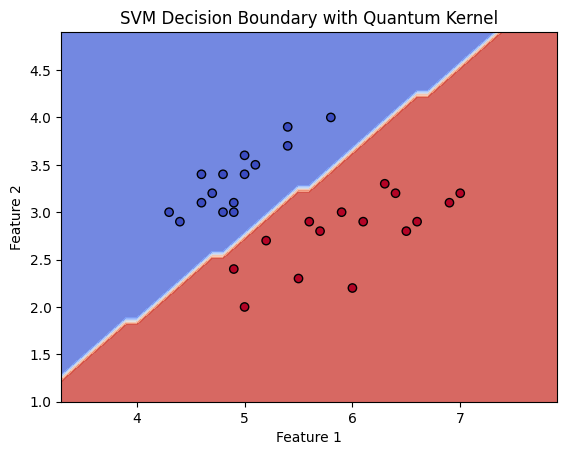

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from joblib import Parallel, delayed
import pennylane as qml

# Assuming you have these variables from previous steps
# X, y, optimized_qek_matrix, optimized_params, X_train, X_test, y_train, y_test

# Use only the first two features for visualization purposes
X_2d = X[:, :2]
X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]

# Define the number of qubits based on the reduced feature set (2 features)
n_qubits = X_2d.shape[1]
dev = qml.device('default.qubit', wires=n_qubits)

# Define a simpler quantum feature map
def quantum_feature_map(x, params):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for i in range(n_qubits):
        qml.RZ(params[i], wires=i)

# Define the variational quantum circuit
@qml.qnode(dev)
def variational_circuit(x, params):
    quantum_feature_map(x, params)
    return qml.state()

# Function to compute the kernel matrix element
def compute_kernel_element(x1, x2, params):
    state_x1 = variational_circuit(x1, params)
    state_x2 = variational_circuit(x2, params)
    return np.abs(np.dot(np.conj(state_x1), state_x2))**2

# Precompute the kernel matrix between the grid points and training data
def compute_kernel_matrix(grid_points, X_train, params):
    kernel_matrix = np.zeros((len(grid_points), len(X_train)))
    for i, grid_point in enumerate(grid_points):
        for j, x_train in enumerate(X_train):
            kernel_matrix[i, j] = compute_kernel_element(grid_point, x_train, params)
    return kernel_matrix

# Create a mesh to plot the decision boundary
h = .1  # Increased step size to reduce number of grid points
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute the kernel matrix for the grid points
grid_kernel_matrix = compute_kernel_matrix(grid_points, X_train_2d, optimized_params)

# Compute the optimized kernel matrix for the reduced 2D training set
def compute_qek_matrix(X, params):
    n_samples = len(X)
    qek_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            qek_matrix[i, j] = compute_kernel_element(X[i], X[j], params)

    return qek_matrix

# Compute the optimized QEK matrix for the reduced 2D training set
optimized_qek_matrix_2d = compute_qek_matrix(X_train_2d, optimized_params)

# Train the SVM classifier on the 2D quantum kernel
svm_2d = SVC(kernel='precomputed')
svm_2d.fit(optimized_qek_matrix_2d, y_train)

# Predict the class for each point in the mesh using the precomputed kernel matrix
Z = svm_2d.predict(grid_kernel_matrix)
Z = Z.reshape(xx.shape)

# Plot the decision boundary by assigning a color to each point in the mesh
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary with Quantum Kernel')
plt.show()
